### Using Vix Historical Data to Predict Bitcoin Investment Return

In this analysis, we attempt to examine Vix historical data and determine if such data can be used to predict return on future Bitcoin investments.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

### Data Collection and Labeling

In [8]:
coin_df = pd.read_csv('Data/coin_Bitcoin.csv')

coin_df.index = pd.to_datetime(coin_df['Date']).dt.date
coin_df.index = pd.DatetimeIndex(coin_df.index)

# Not useful
coin_df.drop('Date', axis=1, inplace=True)
coin_df.drop('SNo', axis=1, inplace=True)
coin_df.drop('Symbol', axis=1, inplace=True)
coin_df.drop('Name', axis=1, inplace=True)

coin_df.head()

,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,
2013-04-29,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
2013-04-30,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2013-05-01,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
2013-05-02,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
2013-05-03,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [9]:
# Add a classification column. The class of each data point is determined by the percent change in close price
# day by day
coin_df['Return'] = coin_df['Close'].pct_change()
# First row in df has NaN 'return' since there is no previous day
coin_df.drop(coin_df.index[0], inplace=True)
coin_df.head()

,High,Low,Open,Close,Volume,Marketcap,Return
Date,,,,,,,
2013-04-30,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09,-0.038328
2013-05-01,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09,-0.158345
2013-05-02,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09,-0.100692
2013-05-03,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09,-0.070906
2013-05-04,115.000000,92.500000,98.099998,112.500000,0.0,1.250317e+09,0.150895


In [10]:
# Next we read in the Vix dataset

new_column_names = {
    'DATE': 'Date',
    'OPEN': 'Open',
    'HIGH': 'High',
    'LOW': 'Low',
    'CLOSE': 'Close'
}

vix_df = pd.read_csv('index_data/VIX_History.csv')

vix_df.rename(columns=new_column_names, inplace=True)

vix_df.index = pd.to_datetime(vix_df['Date']).dt.date
vix_df.index = pd.DatetimeIndex(vix_df.index)

vix_df.drop('Date', axis=1, inplace=True)

vix_df.head()

,Open,High,Low,Close
Date,,,,
1990-01-02,17.24,17.24,17.24,17.24
1990-01-03,18.19,18.19,18.19,18.19
1990-01-04,19.22,19.22,19.22,19.22
1990-01-05,20.11,20.11,20.11,20.11
1990-01-08,20.26,20.26,20.26,20.26


### Data Merging

In [11]:
# Here, we merge the Vix Data with the coin_df Return column

# Clearly, we can see we have data in Vix we will not need (since Bitcoin did not exist in 1990)
# Similarly, we should restrict both datasets to the time range they share
oldest_coin_date = coin_df.index.min()
oldest_vix_date = vix_df.index.min()
newest_coin_date  = coin_df.index.max()
newest_vix_date = vix_df.index.max()
print("Oldest date for Coin DF:", oldest_coin_date)
print("Most recent date for Coin DF:", newest_coin_date)
print()
print("Oldest date for Vix DF:", oldest_vix_date)
print("Most recent date for Vix DF:", newest_vix_date)

oldest_shared = max(oldest_coin_date, oldest_vix_date)
newest_shared = min(newest_coin_date, newest_vix_date)

print()
print("Oldest date shared:", oldest_shared)
print("Most recent date shared:", newest_shared)

vix_df = vix_df.loc[oldest_shared:newest_shared]
coin_df = coin_df.loc[oldest_shared:newest_shared]

Oldest date for Coin DF: 2013-04-30 00:00:00
Most recent date for Coin DF: 2021-02-27 00:00:00

Oldest date for Vix DF: 1990-01-02 00:00:00
Most recent date for Vix DF: 2021-03-26 00:00:00

Oldest date shared: 2013-04-30 00:00:00
Most recent date shared: 2021-02-27 00:00:00


In [14]:
vix_df['Return'] = coin_df['Return']
vix_df.head()

,Open,High,Low,Close,Return
Date,,,,,
2013-04-30,13.71,14.28,13.51,13.52,-0.038328
2013-05-01,13.88,14.67,13.87,14.49,-0.158345
2013-05-02,14.48,14.48,13.58,13.59,-0.100692
2013-05-03,12.92,13.15,12.77,12.85,-0.070906
2013-05-06,13.06,13.19,12.66,12.66,-0.031145


### Data Visualization

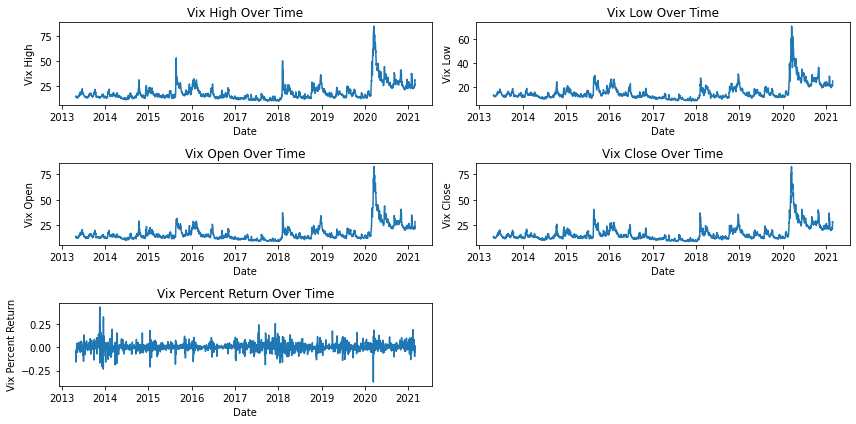

In [17]:
# A basic visualization of Date vs the coin_df columns
fig = plt.figure(figsize=(12, 6))

# High over time
high_axis = fig.add_subplot(3, 2, 1)
high_axis.plot(vix_df.index, vix_df['High'])
high_axis.set_title('Vix High Over Time')
high_axis.set_xlabel('Date')
high_axis.set_ylabel('Vix High')

# Low over time
low_axis = fig.add_subplot(3, 2, 2)
low_axis.plot(vix_df.index, vix_df['Low'])
low_axis.set_title('Vix Low Over Time')
low_axis.set_xlabel('Date')
low_axis.set_ylabel('Vix Low')

# Open over time
open_axis = fig.add_subplot(3, 2, 3)
open_axis.plot(vix_df.index, vix_df['Open'])
open_axis.set_title('Vix Open Over Time')
open_axis.set_xlabel('Date')
open_axis.set_ylabel('Vix Open')

# Close over time
close_axis = fig.add_subplot(3, 2, 4)
close_axis.plot(vix_df.index, vix_df['Close'])
close_axis.set_title('Vix Close Over Time')
close_axis.set_xlabel('Date')
close_axis.set_ylabel('Vix Close')

# Return over time
return_axis = fig.add_subplot(3, 2, 5)
return_axis.plot(vix_df.index, vix_df['Return'])
return_axis.set_title('Vix Percent Return Over Time')
return_axis.set_xlabel('Date')
return_axis.set_ylabel('Vix Percent Return')

plt.tight_layout()
plt.show()

---

### Class Assignment

In [18]:
# Sentiment on return: 
# > .10 then very good 0 < < 0.10 then good converse for bad and very bad
def get_sentiment(return_val):
    if return_val >= 0.10:
        return 'very good'
    elif return_val > 0 and return_val < 0.10:
        return 'good'
    elif return_val <= 0 and return_val > -0.10:
        return 'bad'
    elif return_val <= -0.10:
        return 'very bad'
    else:
        print(return_val)
        return None
# Replace Return column with label
vix_df['Return'] = [get_sentiment(return_val) for return_val in vix_df['Return']]
vix_df.head()

,Open,High,Low,Close,Return
Date,,,,,
2013-04-30,13.71,14.28,13.51,13.52,bad
2013-05-01,13.88,14.67,13.87,14.49,very bad
2013-05-02,14.48,14.48,13.58,13.59,very bad
2013-05-03,12.92,13.15,12.77,12.85,bad
2013-05-06,13.06,13.19,12.66,12.66,bad


In [19]:
# We are faced with a new problem: Class Imbalance. This will be addressed in the next section
class_counts = {}
for class_ in vix_df['Return']:
    class_counts[class_] = class_counts.get(class_, 0) + 1
print(class_counts)

{'bad': 868, 'very bad': 42, 'good': 1005, 'very good': 54}


---

### Model Evaluation/Parameter Tuning

In the next few code blocks, we deal with Class Imbalance issues, and evaluate multiple models with fine-tuned parameters.

In [20]:
# To decide on the best model, we should fine tune the parameters of the models in consideration to see
# the best performances of our models.

# Here, we use a StandardScaler on Vix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

X = vix_df[['Open', 'High', 'Low', 'Close']]
y = vix_df['Return']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

transformer = StandardScaler().fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

### Class Imbalance

As we saw above, the number of "good" vs "bad" data points heavily outweigh the "very good" and "very bad" data points. In the next cell, we attempt to assign class weights to account for this disparity.

In [21]:
# We should now deal with the issue of class_weights
from sklearn.utils import class_weight
labels = np.unique(y_train)
class_weights = dict(zip(labels, class_weight.compute_class_weight('balanced', classes=labels, y=y_train)))
print(class_weights)

{'bad': 0.5722591362126246, 'good': 0.48796033994334276, 'very bad': 10.132352941176471, 'very good': 9.569444444444445}


### Logistic Regression Evaluation

In [22]:
# Logistic Regression Parameter Tuning
from sklearn.linear_model import LogisticRegression
param_grid = {  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
                }

lr = LogisticRegression(max_iter=2000, class_weight=class_weights)
grid = GridSearchCV(lr, param_grid)
grid.fit(X_train, y_train)
print("Best grid score: {:.2f}".format(grid.best_score_))
print("Grid test score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best grid parameters: {}".format(grid.best_params_))
lr_best_params = grid.best_params_

Best grid score: 0.28
Grid test score: 0.32
Best grid parameters: {'C': 0.01}


### Decision Tree Evaluation

In [23]:
# Decision Tree Parameter Tuning
from sklearn.tree import DecisionTreeClassifier
n_components = list(range(1,X.shape[1]+1,1))
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,4,6,8,10,12,14,16,18,20,25,30,40,50,70]
}
dt = DecisionTreeClassifier(class_weight=class_weights)
grid = GridSearchCV(dt, param_grid)
grid.fit(X_train, y_train)
print("Best grid score: {:.2f}".format(grid.best_score_))
print("Grid test score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best grid parameters: {}".format(grid.best_params_))
dt_best_params = grid.best_params_

Best grid score: 0.47
Grid test score: 0.45
Best grid parameters: {'criterion': 'entropy', 'max_depth': 30}


### KNN Evaluation

In [24]:
# K-Nearest Neighbors Parameter Tuning
from sklearn.neighbors import KNeighborsClassifier
param_grid = {
    'n_neighbors': [3, 5, 11, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn = KNeighborsClassifier() # No class_weight param
grid = GridSearchCV(knn, param_grid)
grid.fit(X_train, y_train)
print("Best grid score: {:.2f}".format(grid.best_score_))
print("Grid test score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best grid parameters: {}".format(grid.best_params_))
knn_best_params = grid.best_params_

Best grid score: 0.47
Grid test score: 0.50
Best grid parameters: {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'uniform'}


### SVC Evaluation

In [25]:
# SVC Parameter Tuning
from sklearn.svm import SVC
param_grid = {
    'C':[1,10,100,1000],
    'gamma':[1,0.1,0.001,0.0001],
    'kernel':['linear','rbf']
}
svc = SVC(class_weight=class_weights)
grid = GridSearchCV(svc, param_grid)
grid.fit(X_train, y_train)
print("Best grid score: {:.2f}".format(grid.best_score_))
print("Grid test score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best grid parameters: {}".format(grid.best_params_))
svc_best_params = grid.best_params_

Best grid score: 0.38
Grid test score: 0.01
Best grid parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}


---

### Conclusion

While we did not proceed further with this investigation as done with Bitcoin Historical data, we have made the conclusion that market volatility (represented here through Vix historical data) is not a good predictor for Bitcoin performance.